# Process ContentWise Data

**Goal**: convert ContentWise dataset into pandas format that can be used to train simulator. Infrequent users and items are discarded, a column adding dynamic user state is added, and the dataset is split into train, validate, test users seen in training, and test for users unseen in training.
<br/>
<br/>

In [26]:
import paths
%cd {paths.base}
import os
from os.path import join

%load_ext autoreload
%autoreload 2
from simtrain import utils
from simtrain import SETTINGS_POLIMI as SETTINGS
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
from scipy import stats, sparse
import shutil
from datetime import datetime
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
import json

os.environ['NUMEXPR_MAX_THREADS'] = SETTINGS.NUMEXPR_MAX_THREADS

/root/notebooks/accordion
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_neg_imp = paths.cw_dat_paths['negative_impressions']
path_pos_imp = paths.cw_dat_paths['positive_impressions']
path_clicks = paths.cw_dat_paths['interactions']

In [3]:
df_neg = pd.read_csv(path_neg_imp)
df_pos = pd.read_csv(path_pos_imp)
df_int = pd.read_csv(path_clicks)

### Next step: process positive impressions, negative impressions, and interactions into a single dataframe
Warning: the next cell is memory intensive and will take a long time.

In [4]:
def parse_items(s):
    # convert string representation of items to list of int
    return [int(s0) for s0 in s.split('[')[1].split(']')[0].split(' ') if len(s0)>0]

# populate positive impressions:
df_pos_merged = df_pos.merge(df_int, on='recommendation_id', how='inner')

def convert_ms_days(t0, baseline):
    return (t0 - baseline)/1000/3600/24

start_time_ms = df_pos_merged.utc_ts_milliseconds.min()

UID = []
REC = []
ITM = []
TS = []
RS = []

print('processing interactions:')
for ind,row in tqdm(df_pos_merged.iterrows()):
    vs = parse_items(row.recommended_series_list)
    c = row.recommendation_list_length
    assert len(vs)==c
    v1 = row.series_id
    assert v1 in vs
    t = convert_ms_days(row.utc_ts_milliseconds, start_time_ms)
    # create set of new rows with same rec_id and user_id
    UID += c*[row.user_id]
    REC += c*[row.row_position]
    ITM += vs
    TS += c*[t]
    RS += [((v0==v1) & (row.interaction_type==0)) for v0 in vs]

    
df = pd.DataFrame({'user_id':np.array(UID,dtype='int32'), 
                   'rec_id':np.array(REC,dtype='int32'),
                   'item_id':np.array(ITM,dtype='int32'), 
                   't':np.array(TS,dtype='float32'),
                    'reward':np.array(RS,dtype='float32')})
    
# group all positive events by user:
user_sessions = df[df.reward>0].groupby('user_id')
# keep users who have more than one play: 
valid_users = user_sessions.filter(lambda x: len(x)>1).user_id.unique()

print('\n\nprocessing negative impressions:')
# populate negative impressions:
for ind,row in tqdm(df_neg.iterrows()):
    uid = int(row.user_id)
    if uid in valid_users:
        vs = parse_items(row.recommended_series_list)
        c = row.recommendation_list_length
        # pick random true session for user and assign same timestamp:
        t = user_sessions.get_group(uid).t.sample(n=1)
        # create set of new rows with same rec_id and user_id
        UID += c*[uid]
        REC += c*[int(row.row_position)]
        ITM += vs
        TS += c*[t]
        RS += c*[0]

df_full = pd.DataFrame({'user_id':np.array(UID,dtype='int32'), 
                   'rec_id':np.array(REC,dtype='int32'),
                   'item_id':np.array(ITM,dtype='int32'), 
                   't':np.array(TS,dtype='float32'),
                    'reward':np.array(RS,dtype='float32')})
    
# init user state and cell id with dummary vars for now:
df_full['user_state'] = ''
df_full['cell_id'] = 1

df_full

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,user_id,rec_id,item_id,t,reward,user_state,cell_id
0,20172,0,20128,43.384224,1.0,,1
1,20172,0,6674,43.384224,0.0,,1
2,20172,0,4625,43.384224,0.0,,1
3,20172,0,19462,43.384224,0.0,,1
4,20172,0,19041,43.384224,0.0,,1
...,...,...,...,...,...,...,...
182971128,42152,6,7733,5.066030,0.0,,1
182971129,42152,6,6625,5.066030,0.0,,1
182971130,42152,6,18730,5.066030,0.0,,1
182971131,42152,6,21941,5.066030,0.0,,1


In [7]:
# save intermediary dataframe:
df_full.to_csv(paths.cw_stages['intermediate_0'], compression='gzip')

In [ ]:
df_full = pd.read_csv(paths.cw_stages['intermediate_0'])

In [9]:
df_full.rename(columns={'t':'time',
                  'item_id':'original_action',
                  'user_state':'original_state'}, inplace=True)

In [28]:
# sub-sample users to make everything downstream runnable with a smaller machine 
# (can change SETTINGS parameter if no limits on computation):
subsample_users = np.random.choice(df_full.user_id.unique(), SETTINGS.N_SUBSAMPLE_USERS)
df = df_full[df_full.user_id.isin(subsample_users)]
df.shape

(27451795, 7)

In [29]:
# count actions and discard those with less than 100 impressions or less than 5 streams:
item_ic = df.groupby('original_action').original_action.count()
item_sc = df[df.reward>0].groupby('original_action').original_action.count()
keep_actions = item_ic[(item_ic >= 100) & (item_ic.index.isin(item_sc[item_sc>=5].index))].index

In [30]:
print('num. actions to keep', item_ic[item_ic>=10].index.shape)

num. actions to keep (6527,)


In [31]:
# map original action to sequential actions:

# step 1. build vocab and inverse vocab of action_id
vocab = np.sort(df[df.original_action.isin(keep_actions)].original_action.unique())
inv_vocab = -np.ones(vocab.max()+1, dtype='int64') # -1 means item id is out of set
for i,v in enumerate(vocab):
    inv_vocab[v] = i

print('num nonzero values:',len(np.where(inv_vocab>=0)[0]))
print('len vocab',len(vocab))
print('new vocab',vocab)

# now add a new column with the sequential action ids
action_map = pd.DataFrame({'original_action':vocab, 'action':np.arange(len(vocab),dtype='int64')})

X1 = pd.merge(df, action_map, how='inner', on='original_action')
X1

num nonzero values: 920
len vocab 920
new vocab [   44   118   125   181   204   229   270   325   379   397   430   434
   465   466   470   488   625   643   674   693   702   716   746   795
   797   817   821   850   864   886   901   939   953   982  1033  1050
  1065  1092  1163  1189  1191  1221  1231  1240  1272  1318  1334  1340
  1342  1391  1443  1444  1463  1477  1480  1496  1502  1609  1625  1631
  1649  1686  1725  1746  1771  1813  1842  1964  2017  2078  2082  2084
  2172  2253  2260  2269  2293  2368  2372  2447  2454  2475  2477  2481
  2497  2501  2530  2565  2599  2607  2648  2717  2741  2769  2809  2824
  2825  2868  2920  2928  2950  2960  3053  3062  3107  3122  3134  3198
  3280  3378  3416  3470  3477  3502  3505  3515  3541  3603  3615  3660
  3687  3689  3702  3738  3740  3747  3826  3953  3974  4017  4063  4064
  4080  4149  4152  4157  4159  4164  4172  4260  4262  4264  4272  4274
  4281  4347  4498  4569  4575  4580  4611  4625  4636  4706  4728  4768
  4

,user_id,rec_id,original_action,time,reward,original_state,cell_id,action
0,7077,0,7906,58.834560,0.0,,1,248
1,7077,0,7906,58.834595,0.0,,1,248
2,7077,0,7906,58.836842,0.0,,1,248
3,40907,1,7906,37.302547,0.0,,1,248
4,40157,0,7906,27.222059,1.0,,1,248
...,...,...,...,...,...,...,...,...
21146547,35202,2,5019,5.402604,0.0,,1,165
21146548,35202,1,5019,8.412176,0.0,,1,165
21146549,40043,2,5019,87.481079,0.0,,1,165
21146550,40053,2,5019,23.648912,0.0,,1,165


In [32]:
# now add state representation column which is dynamic:

def create_dynamic_states(X):
    Xstream = X[X['reward']>0]
    print('num. positive actions',Xstream.shape)
    dynamic_states = [] # tracks user state changes, list of tuples [(user_id, time, state)]
    format_state = lambda xs: ':'.join(map(str,xs))
    for user_id,user_imp in X.groupby('user_id'):
        current_state = []
        ds = []
        # iterate over streams that exist in impression data (if any) and update:
        for name,imp in user_imp.sort_values('time')[['action','time','reward','rec_id']].iterrows():
            title = int(imp[0])
            time = imp[1]
            reward = imp[2]
            rec_id = int(imp[3])
            ds.append((user_id, time, title, format_state(current_state), rec_id, reward))
            current_state = current_state.copy()
            if reward>0: current_state.append(title)
        # only append dynamic states if there is a single stream for this user in the impressions
        if len(current_state)>0:
            dynamic_states += ds

    users,times,titles,states,recids,rewards = zip(*dynamic_states)
    return pd.DataFrame({'user_id':users, 'time':times, 'action':titles, 'state':states, 'rec_id':recids, 'reward':rewards})

In [34]:
# parallelize across half as many cores because memory intensive:
cores = max(1, int(int(os.environ['NUMEXPR_MAX_THREADS'])/2))
# need to process each user state at the time of every impression, use parallelism to solve faster:
Xdyn_ = utils.parallelize_fnc_groups(create_dynamic_states, X1, None, 'user_id', cores)

parallelizing across num. partitions 16
num. positive actions (7334, 8)
num. positive actions (6042, 8)
num. positive actions (4347, 8)
num. positive actions (3482, 8)
num. positive actions (2709, 8)
num. positive actions (2271, 8)
num. positive actions (2523, 8)
num. positive actions (2679, 8)
num. positive actions (2338, 8)
num. positive actions (2237, 8)
num. positive actions (2046, 8)
num. positive actions (944, 8)
num. positive actions (216, 8)
num. positive actions (443, 8)num. positive actions
 (963, 8)
num. positive actions (2605, 8)


In [35]:
Xdyn_.to_csv(paths.cw_stages['intermediate_1'], compression='gzip')

In [ ]:
Xdyn_ = pd.read_csv(paths.cw_stages['intermediate_1'])

In [36]:
# annotate original dataset with Xdyn:
X2 = pd.merge(X1, Xdyn_, on=['user_id','time','action'], how='left')

n sesions per user over 1 hour apart 10.22


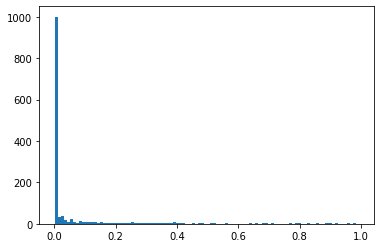

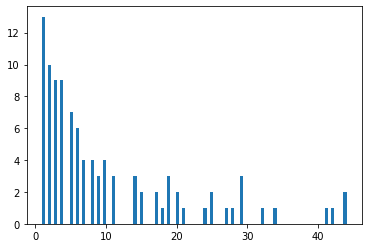

In [37]:
# look histogram of delta t between visits to decide whether further sessionization is needed:
# take subset of 500 users, do on individual level:
dt = []
n_sessions = []
n_sample_users = 100
HOURS_IN_DAY = 24
sub_users = np.random.choice(X1.user_id.unique(), n_sample_users)
for u in sub_users:
    t0 = X1[X1.user_id == u].sort_values('time').time.values
    dt_ = HOURS_IN_DAY*(t0[1:] - t0[:-1])
    n = len(np.unique(dt_[dt_>1.0]))
    n_sessions.append(1+n)
    dt += list(dt_[(dt_ > 0) & (dt_ < 1)])
plt.hist(dt,bins=100)
print('n sesions per user over 1 hour apart', sum(n_sessions)/n_sample_users)
plt.figure()
plt.hist(n_sessions,bins=100)
pass

In [38]:
X3 = Xdyn_

In [39]:
# bucketize time into 30 min time slots:
X3['round_time'] = np.round(X3.time*48)/48

In [40]:
Xus = X3.groupby('user_id')

In [41]:
session_count = Xus.apply(lambda g: g.groupby('round_time').ngroups)

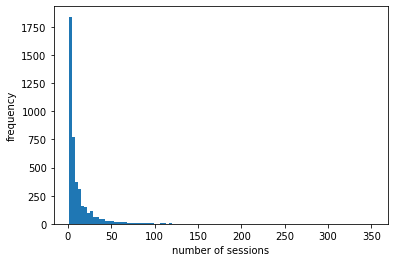

In [42]:
plt.hist(session_count, bins=100)
plt.xlabel('number of sessions')
plt.ylabel('frequency')
pass

In [43]:
print('proportion of users with less than 5 sessions', 
      session_count[session_count < 5].shape[0] / session_count.shape[0])

proportion of users with less than 5 sessions 0.4334511189634865


In [44]:
# keep only those users with 5 or more sessions (discretized by 30 min slots)
keep_users = session_count[session_count >= 5].index
keep_users

Int64Index([   21,    38,    40,    89,    93,    99,   102,   104,   113,
              142,
            ...
            42035, 42075, 42084, 42104, 42113, 42128, 42130, 42132, 42136,
            42142],
           dtype='int64', name='user_id', length=2405)

In [45]:
X4 = X3[X3.user_id.isin(keep_users)]

In [46]:
# now split data into last 28 days test, train-validation-test 50-20-30, 
# remove users with no sessions in their respective quandrants

def split_dataset(X_, prop_train = 0.7, prop_test = 0.3, TEST_TIME_DAYS = 28, seed = 0):
    np.random.seed(seed)
    
    n_users = X_.user_id.nunique()
    user_set = X_.user_id.unique()
    
    train_user_ids = np.random.choice(np.arange(n_users,dtype='int64'), int(n_users*prop_train), replace=False)
    train_users = np.zeros(n_users, dtype='bool') #np.random.binomial(1, prop_train, size=n_users).astype('bool')
    train_users[train_user_ids] = True
    #val_users = (1-train_users)*np.random.binomial(1, prop_val/prop_train, size=n_users).astype('bool')
    test_users = (1 - train_users).astype('bool')
    
    print('stats: prop train users, test users', train_users.sum()/n_users, test_users.sum()/n_users)
    print('n_train_users',train_users.sum(), 'n_test_users',test_users.sum(), 'n_users', n_users)

    # now split by time and save to disk:
    max_time = X_.time.max()
    min_time = X_.time.min()
    assert np.abs(min_time) < 1e-8
    test_time = max_time - TEST_TIME_DAYS
    
    X_train = X_[(X_.time < test_time) & (X_.user_id.isin(user_set[train_users]))]
    X_val = X_[(X_.time < test_time) & (X_.user_id.isin(user_set[test_users]))]
    X_test_seen_users = X_[(X_.time >= test_time) & (X_.user_id.isin(user_set[train_users]))]
    X_test_unseen_users = X_[(X_.time >= test_time) & (X_.user_id.isin(user_set[test_users]))]
    
    N = X_.shape[0]
    print('data sizes as proportion of all data:', 'X_train', X_train.shape[0]/N, 'X_val', X_val.shape[0]/N, 
         'X_test_seen_users', X_test_seen_users.shape[0]/N, 'X_test_unseen_users', X_test_unseen_users.shape[0]/N)
    print('total imp check total', N, ': ', X_train.shape[0] + X_val.shape[0] + X_test_seen_users.shape[0] + X_test_unseen_users.shape[0])
    return [X_train, X_val, X_test_seen_users, X_test_unseen_users]

In [49]:
# save final outputs of processing to split files:

file_names = [paths.cw_stages['output']['train'],
             paths.cw_stages['output']['validate'],
             paths.cw_stages['output']['test-seen'],
             paths.cw_stages['output']['test-unseen']]

Xs = split_dataset(X4)

for x,fn in zip(Xs, file_names):
    x.to_csv(fn, compression='gzip')
print('done.')

stats: prop train users, test users 0.6997920997920998 0.3002079002079002
n_train_users 1683 n_test_users 722 n_users 2405
data sizes as proportion of all data: X_train 0.5352452799169012 X_val 0.2520579176210208 X_test_seen_users 0.14834811103264545 X_test_unseen_users 0.0643486914294326
total imp check total 16057980 :  16057980
done.


In [52]:
# sanity check on state encoding: pick arbitrary users and see if their state matches their actions over time

def display_hist(uids):
    for uid in uids:
        print('uid',uid,'\n',X4[(X4.user_id == uid) & (X4.reward > 0)])
        print('\n\n')
    
display_hist([113, 2604, 19347, 2408])

uid 113 
       user_id       time  action state  rec_id  reward  round_time
1016      113  51.490788     627             0     1.0   51.500000
1552      113  52.480648     627   627       0     1.0   52.479167



uid 2604 
         user_id       time  action                        state  rec_id  \
210239     2604  23.503901     664                                    1   
212289     2604  23.595798     664                          664       1   
215139     2604  27.168600     242                      664:664       1   
215516     2604  30.338091     879                  664:664:242       4   
217690     2604  39.568565     865              664:664:242:879       2   
219518     2604  79.594757     664          664:664:242:879:865       1   
221109     2604  93.314064     664      664:664:242:879:865:664       1   
223888     2604  93.378128     664  664:664:242:879:865:664:664       1   

        reward  round_time  
210239     1.0   23.500000  
212289     1.0   23.604167  
215139     1